# Projet 7 - Prédictions

In [1]:
# Librairies de base
import pandas as pd
print("pandas version:", pd.__version__)
import numpy as np
print("numpy version:", np.__version__)
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version:", matplotlib.__version__)
import imblearn

# Echantillonnage
from imblearn.over_sampling import SMOTE
print("imblearn version:", imblearn.__version__)
from imblearn.under_sampling import RandomUnderSampler

# MLFlow
import mlflow
from mlflow import MlflowClient
from mlflow.tracking import MlflowClient
print("mlflow version:", mlflow.__version__)

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,\
f1_score, roc_auc_score, roc_curve, fbeta_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
print("sklearn version:", sklearn.__version__)
from sklearn.decomposition import PCA

# Modèles de classification
import lightgbm as lgb
print("lightgbm version:", lgb.__version__)
import catboost
from catboost import CatBoostClassifier
print("catboost version:", catboost.__version__)
import xgboost
from xgboost import XGBClassifier
print("xgboost version:", xgboost.__version__)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Autres
import shap # Feature importance
print("shap version:", shap.__version__)

pandas version: 2.2.2
numpy version: 1.26.4
matplotlib version: 3.8.4
imblearn version: 0.12.3
mlflow version: 2.14.2
sklearn version: 1.5.1
lightgbm version: 4.4.0
catboost version: 1.2.5
xgboost version: 2.0.3
shap version: 0.45.1


C:\Users\coren\anaconda3\envs\P7essai1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Objectifs :
    - minimiser les faux négatifs (métrique = recall le plus élevé possible)
    - minimiser les faux positifs (métrique = precision le plus élevé possible)
- Déséquilibres dans le jeu de données : trop de bons clients (0) par rapport aux mauvais clients (1) --> utiliser l'argument class_weight pour résoudre le pb ds la mise en place des modèles

In [2]:
# Création de l'expérience MLFlow

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")
mlflow.set_tracking_uri("http://127.0.0.1:8080")
all_experiments = client.search_experiments()
print(all_experiments)

# Provide an Experiment description that will appear in the UI
#experiment_description = ("Classification des clients projet 7")

# Tag de l'expérience
#experiment_tags = {
#    "project_name": "Projet_7",
#    "mlflow.note.content": experiment_description,
#}

# Create the Experiment, providing a unique name
#projet_7_experiment = client.create_experiment(
#    name="Projet_7", tags=experiment_tags
#)

# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
projet_7_experiment_current = mlflow.set_experiment("Projet_7")
mlflow.set_experiment("Projet_7")
# Define an artifact path that the model will be saved to.
artifact_path = "Projet_7"


[<Experiment: artifact_location='mlflow-artifacts:/445817929057729288', creation_time=1720791165501, experiment_id='445817929057729288', last_update_time=1720791165501, lifecycle_stage='active', name='Projet_7', tags={'mlflow.note.content': 'Classification des clients projet 7',
 'project_name': 'Projet_7'}>, <Experiment: artifact_location='mlflow-artifacts:/181467598177086032', creation_time=1720684342295, experiment_id='181467598177086032', last_update_time=1720684342295, lifecycle_stage='active', name='Apple_Models', tags={'mlflow.note.content': 'This is the grocery forecasting project. This '
                        'experiment contains the produce models for apples.',
 'project_name': 'grocery-forecasting',
 'project_quarter': 'Q3-2023',
 'store_dept': 'produce',
 'team': 'stores-ml'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1720645090927, experiment_id='0', last_update_time=1720645090927, lifecycle_stage='active', name='Default', tags={}>]


## Préparation des données

In [3]:
# Importation de la data

application_train_preprocessed = pd.read_csv("../data/application_train_preprocessed.csv")

In [17]:
display(application_train_preprocessed)

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,True,False,True,False,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,False,False,False,True,False,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,False,False,False,False,True,False,True,False,0,False
307507,307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,False,False,False,False,True,False,True,False,0,True
307508,307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,False,False,False,True,False,False,True,False,0,False
307509,307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,False,False,False,False,True,False,True,False,1,False


In [4]:
# Split train/test

X = application_train_preprocessed.drop('TARGET', axis=1)
y = application_train_preprocessed['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
 # Extraction du nom des variables
features = list(X.columns)

# Imputation valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Suréchantillonnage avec SMOTE
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)

# Sous échantillonnage avec RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Normalisation avec MinMaxScaler, plus adapté que Standard Scaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

"""REDUCTION DIMENSIONS AVEC PCA"""

# Application de la PCA
#pca = PCA()
#X_pca = pca.fit_transform(X_train)

# Calcul de la variance expliquée cumulée
#explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Graphique de la variance expliquée cumulée
#plt.figure(figsize=(10, 6))
#plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
#plt.xlabel('Number of Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title('PCA: Cumulative Explained Variance')
#plt.xticks(np.arange(0, len(explained_variance) + 1, step=10))
#plt.grid(True)
#plt.show()

'REDUCTION DIMENSIONS AVEC PCA'

In [6]:
# Suite de la PCA

# Choix du seuil de variance expliquée
#threshold = 0.98
#n_components = np.argmax(explained_variance >= threshold) + 1
#print("Nombre de composantes :", n_components)

# Application PCA sur les données d'entraînement et de test
#pca = PCA(n_components=n_components)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)

In [7]:
# Mise en forme dataframe

X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (39752, 241)
Testing data shape:  (61503, 241)


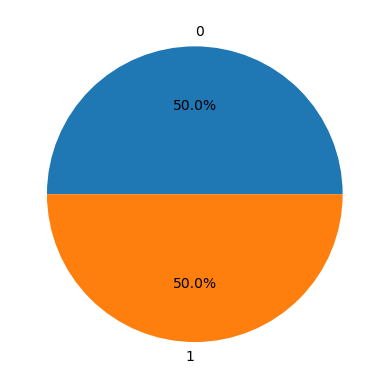

In [8]:
target_counts = y_train.value_counts()
plt.pie(target_counts, labels=['0', '1'], autopct='%1.1f%%')
plt.show()

## Mise en place des fonctions modèle et résultats

In [9]:
beta = 2

In [10]:
f1_beta_scorer = make_scorer(fbeta_score, beta=beta)
#auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
#precision_scorer = make_scorer(precision_score)

# Modèle
def entrainementModeleAvecCV(modele, arguments_modele, param_grid):
    modele = modele(**arguments_modele) # argument class_weight pour gérer déséquilibre des données

    """CROSS VALIDATION"""
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=modele,
                               param_grid=param_grid,
                               scoring=f1_beta_scorer,
                               cv=cv,
                               verbose=0,
                               n_jobs=-1)

    # Entraînement de la cross validation
    grid_search.fit(X_train, y_train)

    print("Meilleurs paramètres trouvés :", grid_search.best_params_)
    print("Meilleur score F1-bêta :", grid_search.best_score_)

    meilleurModele = grid_search.best_estimator_

    #Sauvegarde du modèle
    meilleurModele.save_model('meilleur_modele_catboost.cbm')
    
    """PREDICTIONS"""
    model_pred_proba = meilleurModele.predict_proba(X_test)[:, 1]
    model_pred = meilleurModele.predict(X_test)

    return {
        "modele":modele,
        "hyperparametres": meilleurModele,
        "model_pred_proba": model_pred_proba,
        "model_pred": model_pred,
    }
    
# Entrainement sur le jeu de train
#log_reg.fit(X_train, y_train)

In [11]:
# Mise en place de la fonction de coût

# Définir les coûts
cout_faux_positif = 1
cout_faux_negatif = 10

# Fonction de coût
def calculer_cout(y_test, probas, seuil):
    predictions = (probas > seuil).astype(int)
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    return (fp * cout_faux_positif) + (fn * cout_faux_negatif)

In [15]:
def affichageResultatsModele(model_dict):

    model_pred = model_dict["model_pred"]
    model_pred_proba = model_dict["model_pred_proba"]
    hyperparametres = model_dict["hyperparametres"]
    hyperparametres_dict = model_dict["hyperparametres"].get_params()

    """SEUIL OPTIMAL"""
    
    # Calculer les coûts pour une gamme de seuils
    seuils = np.arange(0, 1, 0.1)
    couts = [calculer_cout(y_test, model_pred_proba, seuil) for seuil in seuils]
    
    # Trouver le seuil optimal
    seuil_optimal = seuils[np.argmin(couts)]
    display("seuil_optimal:",seuil_optimal)
    
    model_pred_classes = (model_pred_proba > seuil_optimal).astype(int)

    """MATRICE DE CONFUSION"""
    cm_optimal = confusion_matrix(y_test, model_pred_classes)    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=['Bons clients', 'Mauvais clients'])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='')
        
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Matrice de Confusion')
    plt.show()

    """METRIQUES"""
    precision = round(precision_score(y_test, model_pred), 4)
    recall = round(recall_score(y_test, model_pred), 4)
    f1 = round(f1_score(y_test, model_pred), 4)
    roc_auc = round(roc_auc_score(y_test, model_pred_proba), 4)
    #f1_beta = round(fbeta_score(y_test, model_pred, beta = beta), 4)
    
    metrics = {"precision":precision, "recall":recall, "f1":f1, "roc_auc":roc_auc}
    display(metrics)

    """FEATURE IMPORTANCE GLOBALE"""

    explainer = shap.Explainer(hyperparametres, X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)

    """ENVOI DANS LE MLFLOW"""
    with mlflow.start_run() as run:
        mlflow.set_tag("model_name", type(hyperparametres).__name__) #nom du modèle
        mlflow.log_params(hyperparametres_dict) #hyperparametres du modèle
        mlflow.log_metrics(metrics) #metriques du modele    
        mlflow.sklearn.log_model(sk_model=hyperparametres, artifact_path="Projet_7")

In [13]:
# Importance locale des caractéristiques pour un échantillon

def featureImportanceLocale(model_dict, individu):
    hyperparametres = model_dict["hyperparametres"]
    shap.initjs()
    explainer = shap.Explainer(hyperparametres, X_train)
    shap_values = explainer(X_test)
    shap.force_plot(shap_values[0].base_values, shap_values[0].values, X_test.iloc[0], feature_names=features)

## Test de différents modèles

#### LogisticRegression

In [ ]:
arguments_modele={}

param_grid = {
    "C": [10, 15, 17],
    "max_iter": [200, 300, 400]
}

LogisticRegression_entraine = entrainementModeleAvecCV(LogisticRegression, arguments_modele, param_grid)
affichageResultatsModele(LogisticRegression_entraine)
#featureImportanceLocale(LogisticRegression_entraine, 0)

#### LightGBM Classifier

In [ ]:
arguments_modele={}

param_grid = {
    "num_leaves":[31, 63, 127],
    "n_estimators":[100,200],
    "max_depth":[3,5],
}

LGBMClassifier_entraine = entrainementModeleAvecCV(lgb.LGBMClassifier, arguments_modele, param_grid)
affichageResultatsModele(LGBMClassifier_entraine)
#featureImportanceLocale(LGBMClassifier_entraine, 0)

#### Catboost Classifier

Meilleurs paramètres trouvés : {'depth': 3, 'early_stopping_rounds': 50, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'n_estimators': 1000, 'verbose': False}
Meilleur score F1-bêta : 0.6874621268648273


'seuil_optimal:'

0.5

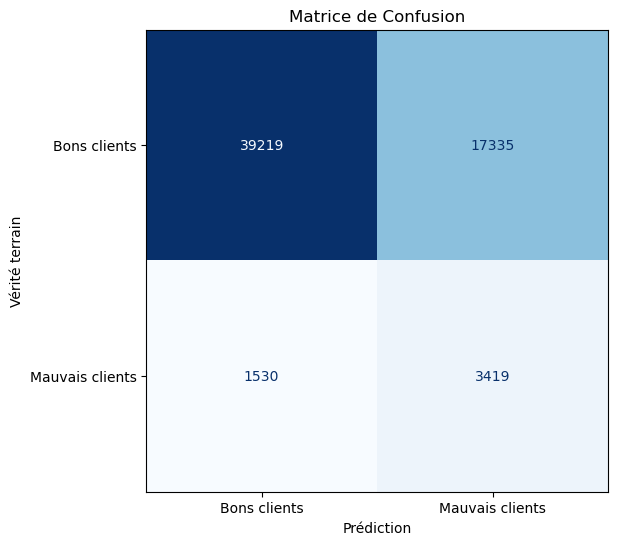

{'precision': 0.1647, 'recall': 0.6908, 'f1': 0.266, 'roc_auc': 0.759}

100%|===================| 61417/61503 [09:30<00:00]        

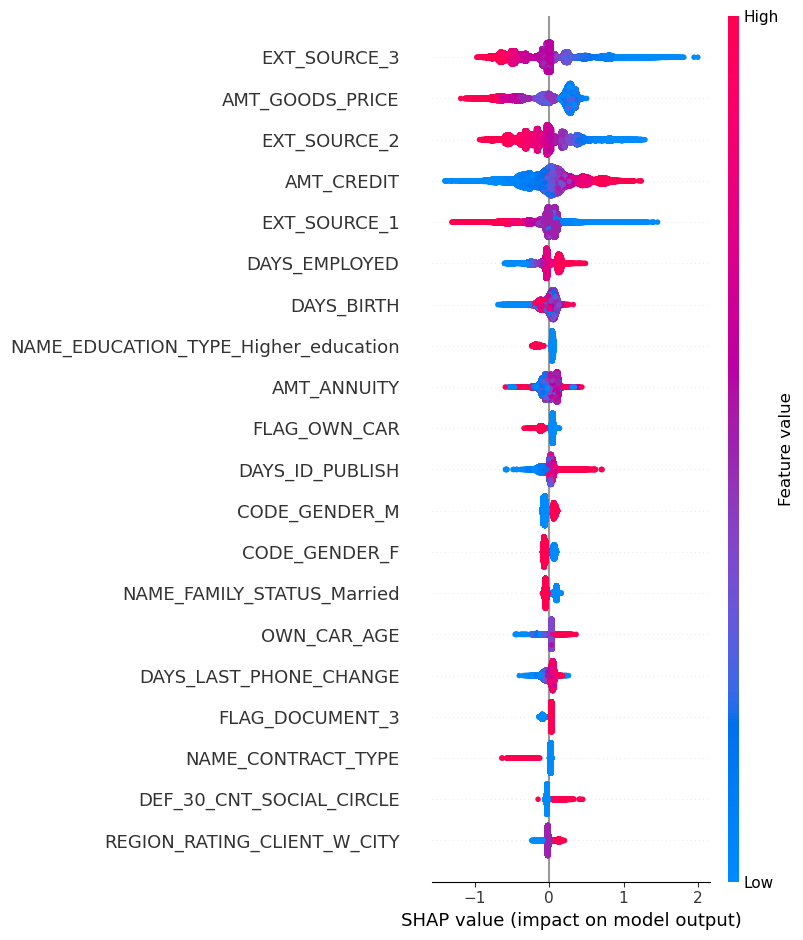

In [16]:
arguments_modele={}

param_grid = {
    'depth': [3],
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'l2_leaf_reg':[3],
    'verbose':[False],
    'early_stopping_rounds':[50],
}

CatBoostClassifier_entraine = entrainementModeleAvecCV(CatBoostClassifier, arguments_modele, param_grid)
affichageResultatsModele(CatBoostClassifier_entraine)
#featureImportanceLocale(CatBoostClassifier_entraine, 0)

#### XGBoost

In [ ]:
# XGBClassifier n'a pas de fonctionnalite intégrée pour équilibrer les classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = class_weights_dict[1] / class_weights_dict[0]

arguments_modele={}

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'gamma':[0, 0.1, 0.2]
}

CatBoostClassifier_entraine = entrainementModeleAvecCV(XGBClassifier, arguments_modele, param_grid)
affichageResultatsModele(CatBoostClassifier_entraine, beta)
#featureImportanceLocale(CatBoostClassifier_entraine, 0)

#### RandomForest

In [ ]:
arguments_modele={}

param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[2,3,4],
    "min_samples_split":[2,3,4],
    "min_samples_leaf":[1,2,3],
}

RandomForestClassifier_entraine = entrainementModeleAvecCV(RandomForestClassifier, arguments_modele, param_grid)
affichageResultatsModele(RandomForestClassifier_entraine)
#featureImportanceLocale(RandomForestClassifier_entraine, 0)